In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist
from nms import nms
from config_voting import *
from copy import *
%matplotlib inline


file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_pickle_VGG/'

oo = 'car'
fname = file_path + 'res_info_' + oo + '_train_carVC.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
            
N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

view_point = np.array(view_point)
idx_s = np.where(np.logical_and(view_point>=67.5,view_point<=112.5))[0]

layer_feature_dist = [layer_feature_dist[nn] for nn in idx_s]

N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

'''
# load original pool4 features
file_cache_feat = '/export/home/qliu24/qing_voting_data/intermediate/feat_VGG/car_mergelist_rand_train_carVC.pickle'
with open(file_cache_feat, 'rb') as fh:
    feat_set, layer_feature_dist = pickle.load(fh)
'''   

magic_thh = 0.85
layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
for lfb in layer_feature_b:
    lfb[0:3, :, :] = 0
    lfb[-3:, :, :] = 0
    lfb[:, 0:3, :] = 0
    lfb[:, -3:, :] = 0
    
max_0 = max([lfb.shape[0] for lfb in layer_feature_b])
max_1 = max([lfb.shape[1] for lfb in layer_feature_b])
max_2 = max([lfb.shape[2] for lfb in layer_feature_b])

print(max_0, max_1, max_2)

loading object car
total number of instances 1000
total number of instances 118
14 54 158


In [2]:
def get_fired_pos_gm(layer_f_dist, layer_f_b, gm_ls, vc_part_cnt, max_0, max_1, max_2):
    heat_map_min = 1/(max_0*max_1)
    hm_BG_val = np.log(heat_map_min)
    
    layer_f_pos = [[[None for hmnn in range(vc_part_cnt[vc_i])] for vc_i in range(max_2)] for nn in range(len(layer_f_dist))]
    
    for lfd_i,lfd in enumerate(layer_f_dist):
        lfb = layer_f_b[lfd_i]
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
            ri, ci = np.where(lfb[:,:,vc_i]==1)
            if ri.size==0:
                continue
            
            pos_lsi = np.column_stack([ri+diff_r, ci+diff_c])
            if vc_part_cnt[vc_i] == 1:
                ass = np.zeros(len(ri))
            elif vc_part_cnt[vc_i] > 1:
                ass = gm_ls[vc_i].predict(pos_lsi)
                
            for kk in range(vc_part_cnt[vc_i]):
                if np.sum(ass==kk) == 0:
                    continue

                det = []
                for pp in zip(ri[ass==kk],ci[ass==kk]):
                    pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                    score2 = (1.7*49-np.sum(pp_dist**2))/10
                    det.append(score2)

                layer_f_pos[lfd_i][vc_i][kk] = pos_lsi[ass==kk][np.argmax(det)]
            
    return layer_f_pos


def get_fired_pos_vct(layer_f_dist, layer_f_b, gm_ls, vc_templates, vc_part_cnt, max_0, max_1, max_2):
    heat_map_min = 1/(max_0*max_1)
    hm_BG_val = np.log(heat_map_min)
    
    layer_f_pos = [[[None for hmnn in range(vc_part_cnt[vc_i])] for vc_i in range(max_2)] for nn in range(len(layer_f_dist))]
    
    for lfd_i,lfd in enumerate(layer_f_dist):
        lfb = layer_f_b[lfd_i]
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
            ri, ci = np.where(lfb[:,:,vc_i]==1)
            if ri.size==0:
                continue
            
            pos_lsi = np.column_stack([ri+diff_r, ci+diff_c])
            if vc_part_cnt[vc_i] == 1:
                ass = np.zeros(len(ri))
            elif vc_part_cnt[vc_i] > 1:
                ass = gm_ls[vc_i].predict(pos_lsi)
                
            for kk in range(vc_part_cnt[vc_i]):
                if np.sum(ass==kk) == 0:
                    continue

                vc_tplt = vc_templates[vc_i][kk]
                det = []
                for pp in zip(ri[ass==kk],ci[ass==kk]):
                    pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                    score2 = (1.7*49-np.sum(pp_dist**2))/10
                    score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))/5
                    det.append(score2+score3)

                layer_f_pos[lfd_i][vc_i][kk] = pos_lsi[ass==kk][np.argmax(det)]
            
    return layer_f_pos


def get_fired_pos(layer_f_dist, layer_f_b, heat_map, vc_part_cnt, vc_part_p, vc_templates):
    max_0, max_1 = heat_map[0][0].shape
    max_2 = len(heat_map)
    heat_map_min = 1/(max_0*max_1)
    hm_BG_val = np.log(heat_map_min)
    
    layer_f_pos = [[[None for hmnn in range(vc_part_cnt[vc_i])] for vc_i in range(max_2)] for nn in range(len(layer_f_dist))]
    
    for lfd_i,lfd in enumerate(layer_f_dist):
        lfb = layer_f_b[lfd_i]
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
            for hmnn in range(vc_part_cnt[vc_i]):
                hm = heat_map[vc_i][hmnn]
                hm_ll = hm[diff_r:diff_r+rll,diff_c:diff_c+cll]
                
                vc_tplt = vc_templates[vc_i][hmnn]
                
                ri, ci = np.where(np.logical_and(lfb[:,:,vc_i]==1,hm_ll[:,:]>0))
                if ri.size==0:
                    continue
                
                pos_lsi = np.column_stack([ri+diff_r, ci+diff_c])
                
                det = []
                for pp in zip(ri, ci):
                    pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                    score1 = np.log(hm_ll[pp[0],pp[1]]) + np.log(vc_part_p[vc_i][hmnn]) - hm_BG_val
                    score2 = (1.7*49-np.sum(pp_dist**2))/10
                    score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))/5
                    det.append(score1+score2+score3)
                    
                layer_f_pos[lfd_i][vc_i][hmnn] = pos_lsi[np.argmax(det)]
                
    return layer_f_pos


def get_heatmap(layer_f_pos, max_0, max_1, max_2, blur=0.5, pctl = None, thrh = None):
    heat_map = [[np.zeros((max_0, max_1)) for hmnn in range(len(layer_f_pos[0][vc_i]))] for vc_i in range(max_2)]
    for vc_i in range(max_2):
        for hmnn in range(len(layer_f_pos[0][vc_i])):
            vc_p = []
            for lfp in layer_f_pos:
                if not(lfp[vc_i][hmnn] is None):
                    vc_p.append(lfp[vc_i][hmnn])
            
            if len(vc_p)==0:
                print('empty vc_p for {0}_{1}'.format(vc_i, hmnn))
                continue
                
            heat_map[vc_i][hmnn] = init_heatmap(vc_p, max_0, max_1, blur, pctl, thrh)
            
    return heat_map


def init_heatmap(vc_p, max_0, max_1, blur=0.5, pctl = None, thrh = None):
    hm = np.zeros((max_0, max_1))
    for pp in vc_p:
        if blur is None:
            hm[pp[0],pp[1]]+=1
        else:
            hm[pp[0],pp[1]]+=1.0-blur
            hm[pp[0]-1:pp[0]+2,pp[1]-1:pp[1]+2]+=blur
            
    if pctl is None and thrh is None:
        thrh = 0
    elif not (pctl is None):
        thrh = np.percentile(hm[hm>0], pctl)
        
    hm[hm<=thrh]=0
    hm /= np.sum(hm)
    return hm


def get_vctplt(layer_f_pos, layer_f_dist, vc_part_cnt, max_0, max_1, max_2):
    vc_templates = [[np.zeros((7,7,0)) for hmnn in range(vc_part_cnt[vc_i])] for vc_i in range(max_2)]
    
    for lfp,lfd in zip(layer_f_pos, layer_f_dist):
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
            for hmnn in range(vc_part_cnt[vc_i]):
                if lfp[vc_i][hmnn] is None:
                    continue
                    
                ri,ci = lfp[vc_i][hmnn]
                rr = ri-diff_r
                cc = ci-diff_c
                patch_dist = lfd[rr-3:rr+4, cc-3:cc+4, vc_i].reshape(7,7,1)
                vc_templates[vc_i][hmnn] = np.concatenate([vc_templates[vc_i][hmnn], patch_dist], axis=2)
                
    for vc_i in range(max_2):
        for hmnn in range(vc_part_cnt[vc_i]):
            vc_templates[vc_i][hmnn] = np.median(vc_templates[vc_i][hmnn], axis=2)
        
    return vc_templates


def get_score(layer_f_dist, layer_f_pos, heat_map, vc_templates, vc_part_cnt, vc_part_p):
    max_0, max_1 = heat_map[0][0].shape
    max_2 = len(heat_map)
    heat_map_min = 1/(max_0*max_1)
    hm_BG_val = np.log(heat_map_min)
    
    total_score = 0
    total_score_details = np.zeros(3)
    for lfd, lfp in zip(layer_f_dist, layer_f_pos):
        rll, cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
        # for vc_i in [17,30,38,81,108]:
            for hmnn in range(vc_part_cnt[vc_i]):
                if lfp[vc_i][hmnn] is None:
                    continue
                
                if vc_part_p[vc_i][hmnn] < 0.1:
                    continue
                    
                rp = lfp[vc_i][hmnn][0] - diff_r
                cp = lfp[vc_i][hmnn][1] - diff_c
                pp_dist = lfd[rp-3:rp+4,cp-3:cp+4, vc_i]
                
                vc_tplt = vc_templates[vc_i][hmnn]
                
                score1 = np.log(heat_map[vc_i][hmnn][lfp[vc_i][hmnn][0],lfp[vc_i][hmnn][1]]) + np.log(vc_part_p[vc_i][hmnn]) - hm_BG_val
                score2 = (1.7*49-np.sum(pp_dist**2))/10
                score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))/5
                
                # print(vc_i,hmnn,score1,score2)
                
                total_score += score1+score2+score3
                total_score_details += np.array([score1,score2,score3])
                
    return total_score/len(layer_f_dist),total_score_details/len(layer_f_dist)
        

def gm_vc_pos(pos_ls, cluster_num):
    gm = GaussianMixture(n_components=cluster_num, covariance_type='full', \
                                  n_init=10, max_iter=1500)
    
    gm.fit(pos_ls)
    assignment = gm.predict(pos_ls)
    return gm, assignment



In [3]:
gm_ls = [None for vc_i in range(max_2)]
vc_part_cnt = np.zeros(max_2).astype(int)
heat_map_init = [[] for vc_i in range(max_2)]

for vc_i in range(max_2):
    if vc_i%20 == 0:
        print('VC idx: {0}'.format(vc_i))
        
    vc_p = []
    for nn in range(N):
        vc_l = layer_feature_b[nn][:,:,vc_i]
        rnum, colnum = vc_l.shape
        diffr = int((max_0-rnum)/2)
        diffc = int((max_1-colnum)/2)
        row_i, col_i = np.where(vc_l==1)
        for pp in zip(row_i,col_i):
            vc_p.append((pp[0]+diffr,pp[1]+diffc))
                
    if len(vc_p)<N/2:
        print('not enough VC firing {0}'.format(vc_i))
        continue
        
    vc_p=np.array(vc_p)
    K=4
    gm, assignment = gm_vc_pos(vc_p, K)
    while True:
        p_dist = pdist(gm.means_)
        if np.any(gm.weights_<0.5/K) or np.any(p_dist<7):
            K -= 1
            if K==1:
                gm = None
                assignment = np.zeros(vc_p.shape[0])
                break
            else:
                gm, assignment = gm_vc_pos(vc_p, K)
        else:
            break
            
    # print('final K: {0}'.format(K), flush='True')
    for kk in range(K):
        heat_map_init[vc_i].append(init_heatmap(vc_p[assignment==kk], max_0, max_1, blur=None, pctl = 10))
        
    gm_ls[vc_i]=gm
    vc_part_cnt[vc_i] = K
    
print(len(gm_ls))

VC idx: 0
not enough VC firing 17
VC idx: 20
not enough VC firing 30
not enough VC firing 38
VC idx: 40
VC idx: 60
VC idx: 80
not enough VC firing 81
VC idx: 100
not enough VC firing 108
not enough VC firing 110
VC idx: 120
VC idx: 140
not enough VC firing 145
not enough VC firing 157
158


In [4]:
layer_fired_pos = get_fired_pos_gm(layer_feature_dist, layer_feature_b, gm_ls, vc_part_cnt, max_0, max_1, max_2)
vc_part_p = [[np.sum([not(layer_fired_pos[nn][vc_i][hmnn] is None) for nn in range(N)])/N for hmnn in range(vc_part_cnt[vc_i])]for vc_i in range(max_2)]
vc_templates = get_vctplt(layer_fired_pos, layer_feature_dist, vc_part_cnt, max_0, max_1, max_2)
# layer_fired_pos = get_fired_pos_vct(layer_feature_dist, layer_feature_b, gm_ls, vc_templates, vc_part_cnt, max_0, max_1, max_2)
layer_fired_pos = get_fired_pos(layer_feature_dist, layer_feature_b, heat_map_init, vc_part_cnt, vc_part_p, vc_templates)

for itt in range(1):
    heat_map = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=0.25, pctl = None, thrh = None)
    vc_part_p = [[np.sum([not(layer_fired_pos[nn][vc_i][hmnn] is None) for nn in range(N)])/N for hmnn in range(vc_part_cnt[vc_i])]for vc_i in range(max_2)]
    sc, sc_d = get_score(layer_feature_dist, layer_fired_pos, heat_map, vc_templates, vc_part_cnt, vc_part_p)
    print(sc, sc_d)
    
    vc_templates = get_vctplt(layer_fired_pos, layer_feature_dist, vc_part_cnt, max_0, max_1, max_2)
    layer_fired_pos = get_fired_pos(layer_feature_dist, layer_feature_b, heat_map, vc_part_cnt, vc_part_p, vc_templates)
    

1298.80508312 [ 505.8320937   615.98743919  176.98555023]


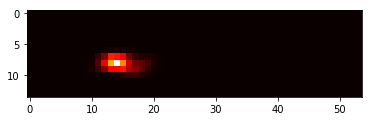

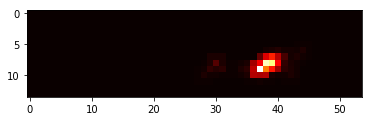

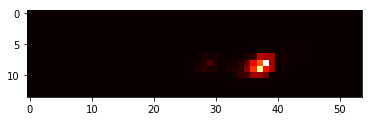

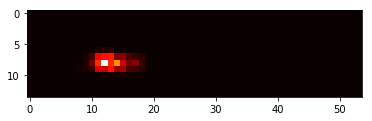

In [5]:
heat_map_i = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=0.25, pctl = None, thrh = None)
vc_i = 0
for hm in heat_map_i[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
vc_i = 1
for hm in heat_map_i[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()

In [16]:
for itt in range(10):
    heat_map = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=0.25, pctl = None, thrh = None)
    vc_part_p = [[np.sum([not(layer_fired_pos[nn][vc_i][hmnn] is None) for nn in range(N)])/N for hmnn in range(vc_part_cnt[vc_i])]for vc_i in range(max_2)]
    sc, sc_d = get_score(layer_feature_dist, layer_fired_pos, heat_map, vc_templates, vc_part_cnt, vc_part_p)
    print(sc, sc_d)
    
    vc_templates = get_vctplt(layer_fired_pos, layer_feature_dist, vc_part_cnt, max_0, max_1, max_2)
    layer_fired_pos = get_fired_pos(layer_feature_dist, layer_feature_b, heat_map, vc_part_cnt, vc_part_p, vc_templates)
    

1442.9128482 [ 540.83837155  700.89252743  201.18194922]
1499.77065479 [ 571.01294644  722.0700822   206.68762614]
1534.71831998 [ 588.93131111  735.33135196  210.45565692]
1555.34089363 [ 599.63050362  742.99234361  212.7180464 ]
1570.8362323 [ 606.57190575  749.53047254  214.73385401]
1581.26175613 [ 611.53182866  753.68279029  216.04713718]
1588.93829064 [ 615.24558088  756.69176745  217.00094232]
1594.02917377 [ 617.61383334  758.72851839  217.68682204]
1598.36947207 [ 619.57933291  760.51071805  218.27942111]
1601.36327354 [ 620.89553026  761.78078218  218.68696111]


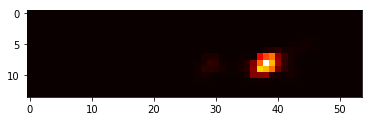

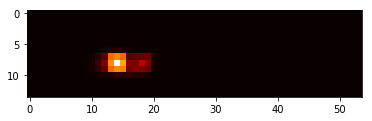

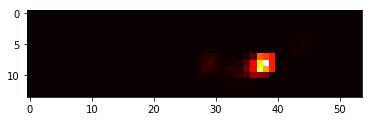

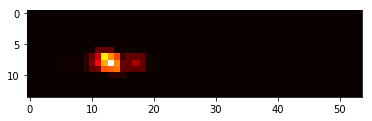

In [24]:
heat_map_ii = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=0.5, pctl = None, thrh = None)
vc_i = 0
for hm in heat_map_ii[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
vc_i = 1
for hm in heat_map_ii[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()

[[ 1.15665208  1.15771138  1.16490266  1.16812898  1.15886492  1.1594994
   1.16774829]
 [ 1.15024843  1.13163039  1.10815616  1.08236165  1.09747624  1.12846686
   1.15390187]
 [ 1.11780925  0.99834631  0.88188718  0.88042734  0.96662931  1.08132105
   1.13583357]
 [ 1.07436962  0.82920381  0.66376859  0.75076063  0.84815225  1.01083133
   1.11459772]
 [ 1.02522978  0.77066491  0.7574316   0.85604157  0.95407053  1.04251984
   1.12090958]
 [ 1.11113884  0.97536479  0.98770431  1.05943408  1.10854145  1.12890549
   1.1493532 ]
 [ 1.15921623  1.14014596  1.13715429  1.15739874  1.16855023  1.17718888
   1.17965205]]


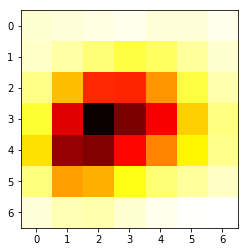

[[ 1.12484218  1.1175641   1.11832055  1.12715478  1.14307146  1.14944037
   1.15593264]
 [ 1.09214906  1.07501919  1.05828486  1.07665346  1.09340146  1.12626173
   1.14543651]
 [ 1.09406077  0.9989983   0.89288469  0.88462851  0.93831097  1.04227898
   1.11229974]
 [ 1.10156716  0.88184219  0.71841027  0.71804063  0.79957195  0.94215363
   1.07984511]
 [ 1.0979778   0.81905981  0.71086011  0.7414252   0.87729223  0.97900965
   1.0738026 ]
 [ 1.12676662  0.98792953  0.89551754  0.97821482  1.05252959  1.09760985
   1.13042197]
 [ 1.16012326  1.14872189  1.10570304  1.12763817  1.15655142  1.16753775
   1.1709283 ]]


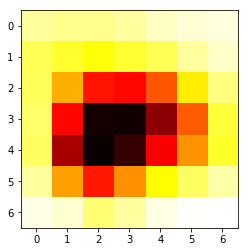

In [20]:
vc_i=1
for vct in vc_templates[vc_i]:
    print(vct)
    plt.imshow(vct, cmap='hot', interpolation='nearest')
    plt.show()

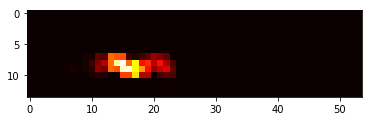

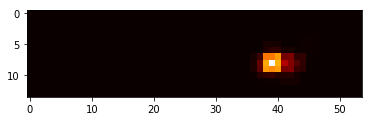

In [29]:
fn = '/export/home/qliu24/qing_voting_data/intermediate/VCpart_model_car/VCpart_model_car_K4_term2.pickle'
with open(fn, 'rb') as fh:
    hmf, _ = pickle.load(fh)
    
vc_i = 0
for hm in hmf[3][vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()

In [22]:
len(hmf)

4